In [65]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import log_loss, classification_report
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.model_selection import StratifiedKFold

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import Pool, CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

In [66]:
train = pd.read_csv('./open/train.csv', index_col='index').reset_index(drop=True)
test = pd.read_csv('./open/test.csv', index_col='index').reset_index(drop=True)

## Encoding

In [67]:
train['occyp_type'] = train['occyp_type'].fillna('None')
test['occyp_type'] = test['occyp_type'].fillna('None')

In [68]:
train['UNEMPLOYED'] = train['DAYS_EMPLOYED'].map(lambda x: 1 if x>0 else 0).astype('object')
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].map(lambda x: 0 if x>0 else x)

test['UNEMPLOYED'] = test['DAYS_EMPLOYED'].map(lambda x: 1 if x>0 else 0).astype('object')
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].map(lambda x: 0 if x>0 else x)

In [69]:
train.loc[train['child_num']>=4,'child_num']= 4
test.loc[test['child_num']>=4,'child_num']= 4

In [70]:
train['worktm']=-(train['DAYS_EMPLOYED'])/365
test['worktm']=-(test['DAYS_EMPLOYED'])/365

In [71]:
train.loc[train['family_size']>=5,'family_size']= 5
test.loc[test['family_size']>=5,'family_size']= 5

In [72]:
train.loc[train['income_type']=='Pensioner', 'income_type']='State servant'
train.loc[train['income_type']=='Student', 'income_type']='State servant'

test.loc[test['income_type']=='Pensioner', 'income_type']='State servant'
test.loc[test['income_type']=='Student', 'income_type']='State servant'

In [73]:
train.loc[(train['occyp_type']=='Cleaning staff') | (train['occyp_type']=='Cooking staff') | (train['occyp_type']=='Drivers') | (train['occyp_type']=='Laborers') | (train['occyp_type']=='Low-skill Laborers') | (train['occyp_type']=='Security staff') | (train['occyp_type']=='Waiters/barmen staff'),'occyp_group']='Laborwk'
train.loc[(train['occyp_type']=='Accountants') | (train['occyp_type']=='Core staff') | (train['occyp_type']=='HR staff') | (train['occyp_type']=='Medicine staff') | (train['occyp_type']=='Private service staff') | (train['occyp_type']=='Realty agents') | (train['occyp_type']=='Sales staff') | (train['occyp_type']=='Secretaries'),'occyp_group']='officewk'
train.loc[(train['occyp_type']=='Managers') | (train['occyp_type']=='High skill tech staff') | (train['occyp_type']=='IT staff'),'occyp_group']='hightecwk'

test.loc[(test['occyp_type']=='Cleaning staff') | (test['occyp_type']=='Cooking staff') | (test['occyp_type']=='Drivers') | (test['occyp_type']=='Laborers') | (test['occyp_type']=='Low-skill Laborers') | (test['occyp_type']=='Security staff') | (test['occyp_type']=='Waiters/barmen staff'),'occyp_group']='Laborwk'
test.loc[(test['occyp_type']=='Accountants') | (test['occyp_type']=='Core staff') | (test['occyp_type']=='HR staff') | (test['occyp_type']=='Medicine staff') | (test['occyp_type']=='Private service staff') | (test['occyp_type']=='Realty agents') | (test['occyp_type']=='Sales staff') | (test['occyp_type']=='Secretaries'),'occyp_group']='officewk'
test.loc[(test['occyp_type']=='Managers') | (test['occyp_type']=='High skill tech staff') | (test['occyp_type']=='IT staff'),'occyp_group']='hightecwk'

In [74]:
train['occyp_group'] = train['occyp_group'].fillna('None')
test['occyp_group'] = test['occyp_group'].fillna('None')

In [75]:
train.loc[train['edu_type']=='Academic degree','edu_type']= 'Higher education'
test.loc[test['edu_type']=='Academic degree','edu_type']= 'Higher education'

In [76]:
# train['income_edu'] = train['income_type'] + '-' + train['edu_type'].astype('object')
# test['income_edu'] = test['income_type'] + '-' + test['edu_type'].astype('object')

In [77]:
# train['occyp_edu'] = train['occyp_type'] + '-' + train['edu_type'].astype('object')
# test['occyp_edu'] = test['occyp_type'] + '-' + test['edu_type'].astype('object')

In [78]:
# train['reality_car'] = train['reality'] + '-' + train['car']
# test['reality_car'] = test['reality'] + '-' + test['car']

In [79]:
edu_list = ['Lower secondary', 'Secondary / secondary special', 'Incomplete higher', 'Higher education']
income_list = ['Working', 'State servant', 'Commercial associate']
# reality_car_type = ['N-N', 'N-Y', 'Y-N', 'Y-Y']

train['edu_type'] = train['edu_type'].map(lambda x: edu_list.index(x))
train['income_type'] = train['income_type'].map(lambda x: income_list.index(x)) 
# train['reality_car'] = train['reality_car'].map(lambda x: reality_car_type.index(x)) 

test['edu_type'] = test['edu_type'].map(lambda x: edu_list.index(x)) 
test['income_type'] = test['income_type'].map(lambda x: income_list.index(x)) 
# test['reality_car'] = test['reality_car'].map(lambda x: reality_car_type.index(x)) 

In [80]:
train['phone_total'] = train['FLAG_MOBIL'] + train['work_phone'] + train['phone']
test['phone_total'] = test['FLAG_MOBIL'] + test['work_phone'] + test['phone']

In [81]:
CATEGORY_COL = [col for col in train.columns if train[col].dtype == 'object']
# CATEGORY_COL = ['gender', 'car', 'reality', 'email', 'family_type', 'house_type', 'UNEMPLOYED', 'income_edu', 'income_occyp', 'occyp_edu']
# CATEGORY_COL = ['gender', 'car', 'reality', 'income_edu', 'UNEMPLOYED', 'family_type', 'house_type', 'income_type', 'edu_type', 'family_house']
NUMERIC_COL = [col for col in train.columns if train[col].dtype != 'object' and col!='credit']

FEATURES = CATEGORY_COL + NUMERIC_COL
TARGET = ['credit']

train = train[FEATURES+TARGET]
test = test[FEATURES]

In [82]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(interaction_only=True, include_bias=False)
ohe = OneHotEncoder(handle_unknown='ignore')

ohe.fit(train.loc[:, CATEGORY_COL])

train_onehot_df = pd.DataFrame(ohe.transform(train.loc[:,CATEGORY_COL]).toarray(), 
                               columns=ohe.get_feature_names(CATEGORY_COL))
train = train.drop(CATEGORY_COL, axis=1)

train = pd.concat([train, train_onehot_df], axis=1)

# train_poly_df = pd.DataFrame(poly.fit_transform(train_onehot_df), 
#                                columns=poly.get_feature_names())

# train = pd.concat([train, train_poly_df], axis=1)

In [83]:
test_onehot_df = pd.DataFrame(ohe.transform(test.loc[:,CATEGORY_COL]).toarray(), 
                              columns=ohe.get_feature_names(CATEGORY_COL))
test = test.drop(CATEGORY_COL, axis=1)

test = pd.concat([test, test_onehot_df], axis=1)

# test_poly_df = pd.DataFrame(poly.transform(test_onehot_df),
#                               columns=poly.get_feature_names())

# test = pd.concat([test, test_poly_df], axis=1)

In [84]:
print(train.shape)
print(test.shape)

(26457, 57)
(10000, 56)


In [106]:
param = {'boosting_type':'gbdt',
         'max_depth':-1, 
         'num_leaves':64,
         'objective': 'multi-class',
         'n_estimators':2000, 
         'learning_rate':0.03, 
         'subsample':0.8, 
         'colsample_bytree':0.8}

In [93]:
FEATURES = [col for col in train.columns if col!='credit']

In [107]:
oof_lgb = np.zeros((len(train),3))
lgb_pred = np.zeros((len(test),3))
feature_importance_df = pd.DataFrame()

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold_, (trn_idx, val_idx) in enumerate(skf.split(train, train['credit'])):
    print("\nfold num_: {}".format(fold_))
    y_train, y_valid = train.iloc[trn_idx][TARGET], train.iloc[val_idx][TARGET]
    X_train, X_valid = train.iloc[trn_idx][FEATURES], train.iloc[val_idx][FEATURES]
    
    clf = LGBMClassifier(**param)
    clf.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)], 
            early_stopping_rounds=100,
            verbose=100)
    
    oof_lgb[val_idx] = clf.predict_proba(X_valid, num_iteration=clf.best_iteration_)    
    lgb_pred += clf.predict_proba(test[FEATURES], num_iteration=clf.best_iteration_)

lgb_pred /= 5    
print('\nCross Validation Is Complete')                           
print("CV score: {:<8.5f}".format(log_loss(train[TARGET], oof_lgb)))


fold num_: 0
Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.742005	valid_1's multi_logloss: 0.780431
[200]	training's multi_logloss: 0.696943	valid_1's multi_logloss: 0.763218
[300]	training's multi_logloss: 0.661592	valid_1's multi_logloss: 0.752333
[400]	training's multi_logloss: 0.631627	valid_1's multi_logloss: 0.743917
[500]	training's multi_logloss: 0.605334	valid_1's multi_logloss: 0.739291
[600]	training's multi_logloss: 0.581263	valid_1's multi_logloss: 0.736448
[700]	training's multi_logloss: 0.558991	valid_1's multi_logloss: 0.733872
[800]	training's multi_logloss: 0.538566	valid_1's multi_logloss: 0.731586
[900]	training's multi_logloss: 0.520279	valid_1's multi_logloss: 0.730251
[1000]	training's multi_logloss: 0.503419	valid_1's multi_logloss: 0.729253
[1100]	training's multi_logloss: 0.486915	valid_1's multi_logloss: 0.727724
[1200]	training's multi_logloss: 0.471396	valid_1's multi_logloss: 0.727746
[1300]	training's mul

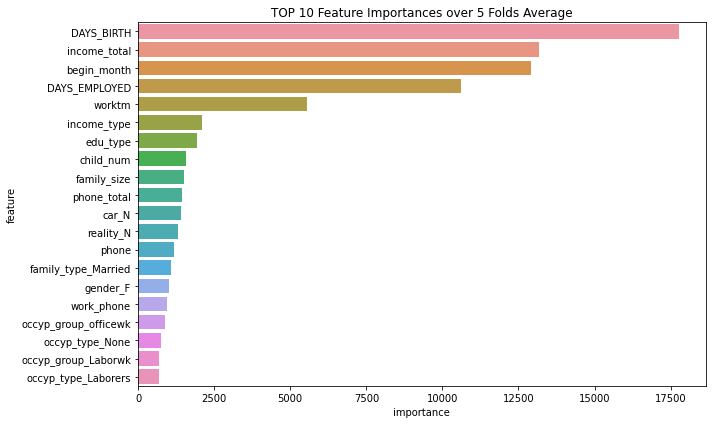

In [108]:
feature_importance = pd.DataFrame({'feature':clf.feature_name_, 'importance':clf.feature_importances_})

plt.figure(figsize=(10,6))
sns.barplot(x='importance', 
            y='feature', 
            data=feature_importance.sort_values(by="importance", ascending=False).reset_index()[:20])

plt.title('TOP 10 Feature Importances over 5 Folds Average')
plt.tight_layout()

In [114]:
result = permutation_importance(clf, X_train, y_train, n_repeats=10,
                                random_state=42, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_train.columns[sorted_idx])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

KeyboardInterrupt: 

In [179]:
submit = pd.read_csv('./open/sample_submission.csv')

submit.iloc[:, 1:] = (lgb_pred+cat_pred)/2
submit.to_csv('./lgb_cat.csv', index=False)

In [180]:
submit

,index,0,1,2
0,26457,0.051637,0.085315,0.863049
1,26458,0.140120,0.150102,0.709778
2,26459,0.056348,0.114691,0.828961
3,26460,0.114377,0.083121,0.802502
4,26461,0.066146,0.187739,0.746115
...,...,...,...,...
9995,36452,0.165179,0.183425,0.651396
9996,36453,0.187163,0.282489,0.530349
9997,36454,0.023807,0.086053,0.890141
9998,36455,0.132550,0.234612,0.632838


In [178]:
model = CatBoostClassifier(loss_function='MultiClass', 
                           depth = 9,
                           early_stopping_rounds=100,
                           task_type="GPU",
                           random_state=42,
                           learning_rate=0.05,
                           iterations=5000)

skf = StratifiedKFold(n_splits=5, random_state=74, shuffle=True)


oof_cat = np.zeros((len(train), 3))
cat_pred = np.zeros((len(test), 3))


for idx, (trn_idx, val_idx) in enumerate(skf.split(train, train['credit'])):
    y_train, y_valid = train.iloc[trn_idx][TARGET], train.iloc[val_idx][TARGET]
    X_train, X_valid = train.iloc[trn_idx][FEATURES], train.iloc[val_idx][FEATURES]
    
    _train = Pool(X_train, label=y_train)
    _valid = Pool(X_valid, label=y_valid)
    
    print( "\nFold ", idx)
    fit_model = model.fit(_train,
                          eval_set=_valid,
                          use_best_model=True,
                          verbose=200
                         )
    pred = fit_model.predict_proba(X_valid)
    print( "  Log loss = ", log_loss(y_valid, pred) )
    oof_cat[val_idx] = pred
    cat_pred += fit_model.predict_proba(test[FEATURES])
cat_pred /= 5
print("CV score: {:<8.5f}".format(log_loss(train[TARGET], oof_cat)))


Fold  0
0:	learn: 1.0695328	test: 1.0698417	best: 1.0698417 (0)	total: 10.8ms	remaining: 54s
200:	learn: 0.7129480	test: 0.7723420	best: 0.7723420 (200)	total: 1.99s	remaining: 47.4s
400:	learn: 0.6398090	test: 0.7546691	best: 0.7546691 (400)	total: 3.81s	remaining: 43.7s
600:	learn: 0.5849450	test: 0.7454504	best: 0.7454504 (600)	total: 5.86s	remaining: 42.9s
800:	learn: 0.5426131	test: 0.7403600	best: 0.7403600 (800)	total: 7.7s	remaining: 40.4s
1000:	learn: 0.5081815	test: 0.7384131	best: 0.7384131 (1000)	total: 9.62s	remaining: 38.4s
bestTest = 0.7382042064
bestIteration = 1049
Shrink model to first 1050 iterations.
  Log loss =  0.7382041721117514

Fold  1
0:	learn: 1.0698139	test: 1.0695063	best: 1.0695063 (0)	total: 8.51ms	remaining: 42.5s
200:	learn: 0.7172604	test: 0.7663680	best: 0.7663680 (200)	total: 1.91s	remaining: 45.6s
400:	learn: 0.6468369	test: 0.7458203	best: 0.7458203 (400)	total: 3.76s	remaining: 43.1s
600:	learn: 0.5934359	test: 0.7350320	best: 0.7350320 (600)	to

In [226]:
param

{'boosting_type': 'goss',
 'max_depth': 9,
 'num_leaves': 128,
 'objective': 'multi-class',
 'n_estimators': 2000,
 'learning_rate': 0.03,
 'subsample': 0.7,
 'colsample_bytree': 0.7}

In [100]:
from xgboost import XGBClassifier

xgb_params={'learning_rate':0.05,
            'booster': 'gbtree',
            'n_estimators': 2000,
            'max_depth':-1,
            'objective':'multi:softprob',
            'num_class':3,
            'subsample':0.8,
            'colsample_bytree':0.8,
            'random_state':42,
            'tree_method':'gpu_hist',
            'gpu_id': 0,
            'n_jobs': -1,
            'predictor':'gpu_predictor'}

In [101]:
XGBClassifier(**xgb_params)

XGBClassifier(base_score=None, booster='gbtree', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.8, gamma=None, gpu_id=0,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.05, max_delta_step=None, max_depth=-1,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=2000, n_jobs=-1, num_class=3, num_parallel_tree=None,
              objective='multi:softprob', predictor='gpu_predictor',
              random_state=42, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=0.8, tree_method='gpu_hist',
              validate_parameters=None, verbosity=None)

In [102]:
oof_xgb = np.zeros((len(train),3))
xgb_pred = np.zeros((len(test),3))

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=55)

for fold_, (trn_idx, val_idx) in enumerate(skf.split(train, train['credit'])):
    print("\nfold num_: {}".format(fold_))
    y_train, y_valid = train.iloc[trn_idx][TARGET], train.iloc[val_idx][TARGET]
    X_train, X_valid = train.iloc[trn_idx][FEATURES], train.iloc[val_idx][FEATURES]
    
    clf = XGBClassifier(**xgb_params)
    clf.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)], 
            eval_metric= 'mlogloss',
            early_stopping_rounds=100,
            verbose=100
           )
    
    oof_xgb[val_idx] = clf.predict_proba(X_valid, ntree_limit=clf.best_iteration)    
    xgb_pred += clf.predict_proba(test[FEATURES], ntree_limit=clf.best_iteration)

xgb_pred /= 5    
print('\nCross Validation Is Complete')                           
print("CV score: {:<8.5f}".format(log_loss(train[TARGET], oof_xgb)))


fold num_: 0


XGBoostError: value -1 for Parameter max_depth should be greater equal to 0
max_depth: Maximum depth of the tree; 0 indicates no limit; a limit is required for depthwise policy

In [183]:
submit = pd.read_csv('./open/sample_submission.csv')

submit.iloc[:, 1:] = (lgb_pred+cat_pred+xgb_pred)/3
submit.to_csv('./0411_3_ensemble.csv', index=False)

In [96]:
submit = pd.read_csv('./open/sample_submission.csv')

submit.iloc[:, 1:] = (xgb_pred)
submit.to_csv('./0412_xgb_pred.csv', index=False)

In [91]:
xgb_pred

array([[0.04216759, 0.0782714 , 0.87956103],
       [0.2105627 , 0.17055685, 0.61888044],
       [0.041058  , 0.09921888, 0.85972311],
       ...,
       [0.01654804, 0.05220013, 0.93125182],
       [0.08651753, 0.21743858, 0.69604388],
       [0.07326753, 0.23325972, 0.69347275]])